# Import Subhalo Properties from Galacticus Output

This notebook demonstrates crating a halo realization from a galacticus output file.

In [1]:
from pyHalo.Halos.galacticus_util.galacticus_util import *
from pyHalo.Halos.galacticus_util.galacticus_nodedata_filter import *
from pyHalo.preset_models import DMFromGalacticus
from pyHalo.Halos.HaloModels.TNFWFromParams import TNFWFromParams
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import Axes


galacticusfile = GalacticusFileReader.read_file("data/TNFW_example.hdf5")

In [2]:
#Create realization from galacticus file
tree_n = 5
mrange = (1E9,1E10)

realization = DMFromGalacticus(0.5,2,galacticusfile,{},mrange,False,None,None,tree_n,include_field_halos=False,rho_s_use_galacticus=False)
subhalos = realization.halos


#Import nodedata from galacticus
nodedata = tabulate_node_data(galacticusfile)

filter_subhalos = nodedata_filter_subhalos(nodedata)
filter_virialized = nodedata_filter_virialized(nodedata)
filter_mass = nodedata_filter_massrange(nodedata,mrange,GalacticusParameters.MASS_BOUND)
filter_tree = nodedata_filter_tree(nodedata,tree_n)

nodedata = nodedata_apply_filter(nodedata,filter_subhalos & filter_virialized & filter_mass & filter_tree)

## Basic tests
Similar tests should be implemented as a unit teswt in the future.

### Comparison between properties from galacticus and properties from realization

In [3]:
print(f"Number of galacticus subhalos {len(nodedata[GalacticusParameters.MASS_BASIC])}")
print(f"Number of realization subhalos {len(subhalos)}")


Number of galacticus subhalos 99
Number of realization subhalos 99


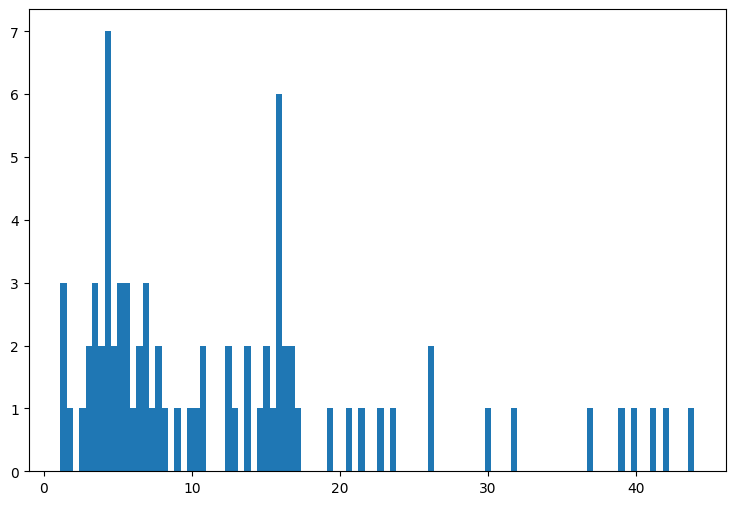

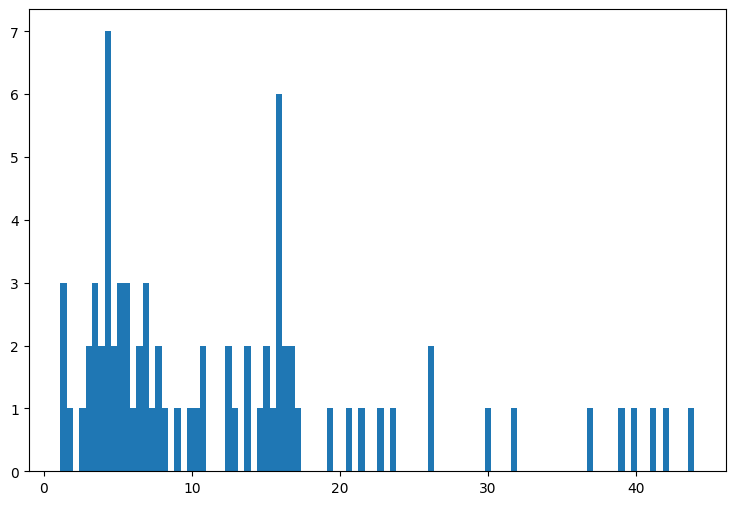

In [4]:
fig, ax = plt.subplots(figsize = (9, 6))

test:TNFWFromParams = subhalos[0]

r_trunc_galacticus = nodedata[GalacticusParameters.TNFW_RADIUS_TRUNCATION] * 1E3
r_trunc_realization = np.asarray([sh.params_physical[TNFWFromParams.KEY_RT] for sh in subhalos])


ax.hist(r_trunc_realization[r_trunc_realization < 100],bins=100);


fig, ax = plt.subplots(figsize = (9, 6))

test:TNFWFromParams = subhalos[0]

ax.hist(r_trunc_galacticus[r_trunc_galacticus < 100],bins=100);


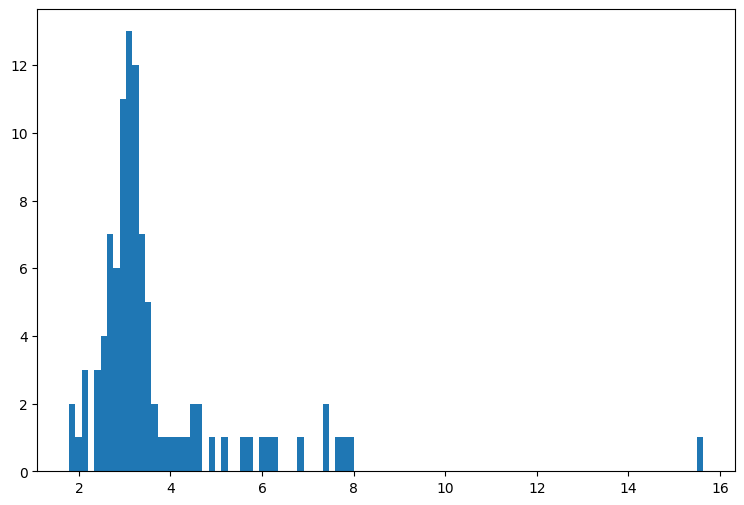

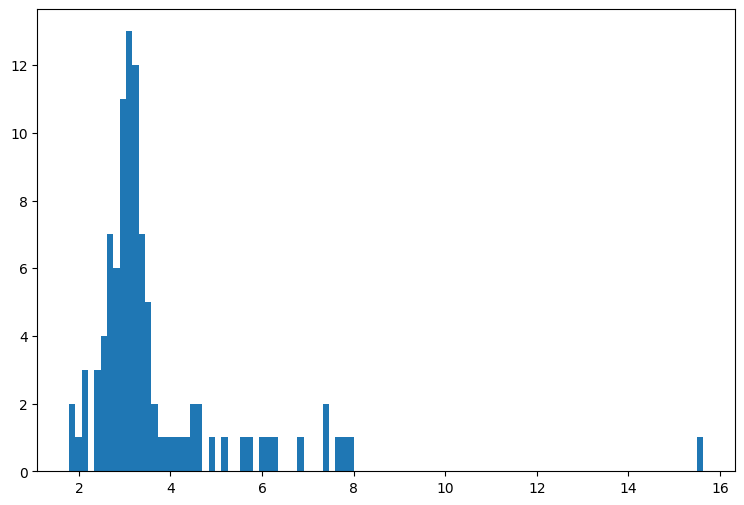

In [5]:
fig, ax = plt.subplots(figsize = (9, 6))

test:TNFWFromParams = subhalos[0]

rs_galacticus = nodedata[GalacticusParameters.SCALE_RADIUS] * 1E3
rs_realization = np.asarray([sh.params_physical[TNFWFromParams.KEY_RS] for sh in subhalos])


ax.hist(rs_realization[rs_realization < 100],bins=100);


fig, ax = plt.subplots(figsize = (9, 6))

test:TNFWFromParams = subhalos[0]

ax.hist(rs_galacticus[rs_galacticus < 100],bins=100);

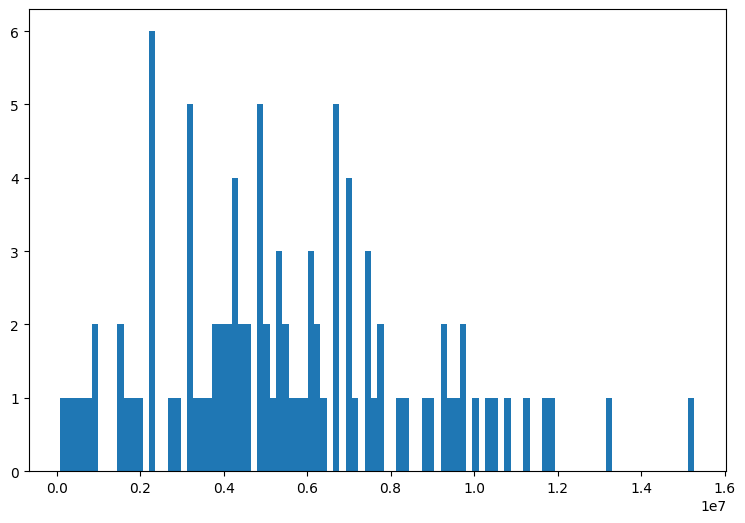

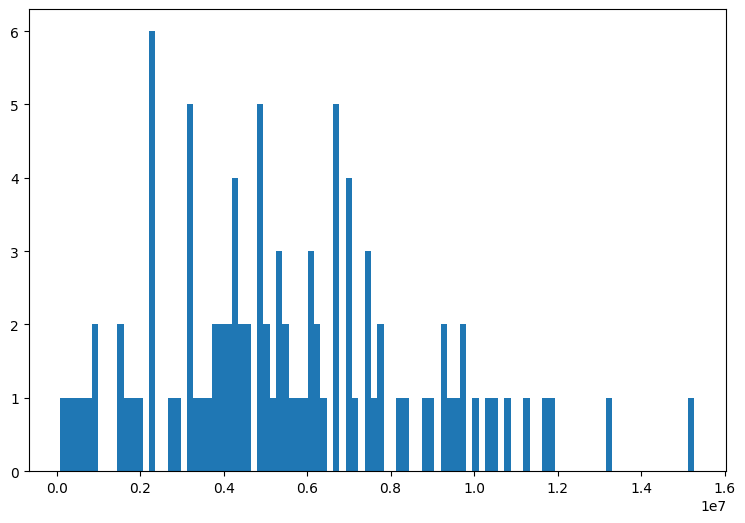

In [6]:
fig, ax = plt.subplots(figsize = (9, 6))

test:TNFWFromParams = subhalos[0]

rho_s_galacticus = nodedata[GalacticusParameters.TNFW_RHO_S] * 1E3
rho_s_realization = np.asarray([sh.params_physical[TNFWFromParams.KEY_RHO_S] for sh in subhalos])


ax.hist(rho_s_realization,bins=100);


fig, ax = plt.subplots(figsize = (9, 6))

test:TNFWFromParams = subhalos[0]

ax.hist(rho_s_realization,bins=100);

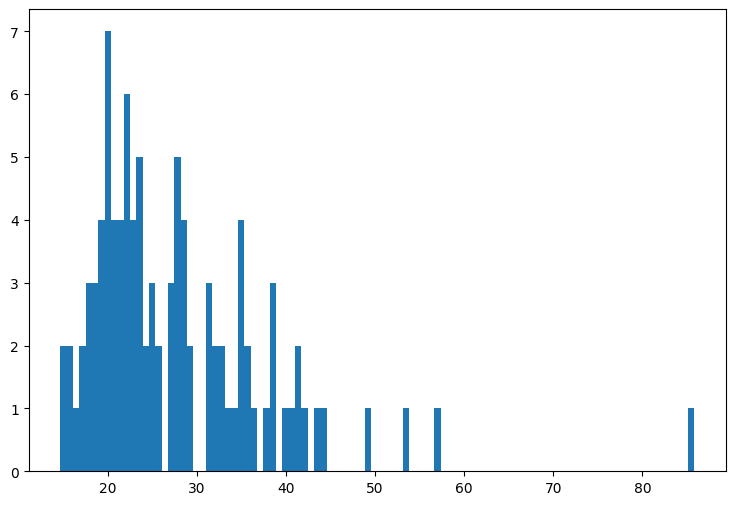

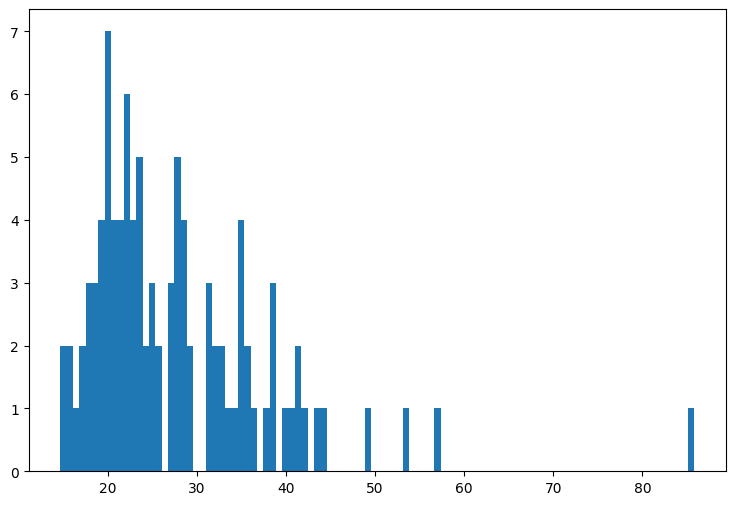

In [7]:
fig, ax = plt.subplots(figsize = (9, 6))

test:TNFWFromParams = subhalos[0]

rv_galacticus = nodedata[GalacticusParameters.RVIR] * 1E3
rv_realization = np.asarray([sh.params_physical[TNFWFromParams.KEY_RV] for sh in subhalos])


ax.hist(rv_realization[rv_realization < 100],bins=100);


fig, ax = plt.subplots(figsize = (9, 6))

test:TNFWFromParams = subhalos[0]

ax.hist(rv_galacticus[rv_galacticus < 100],bins=100);

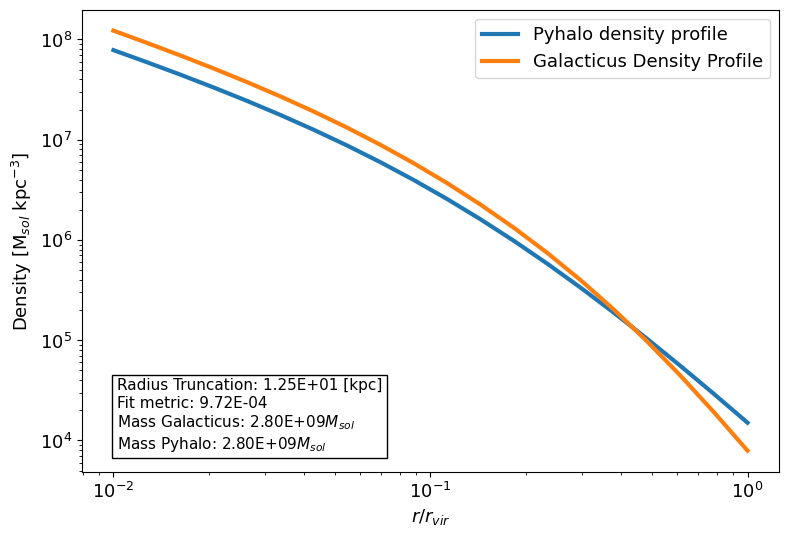

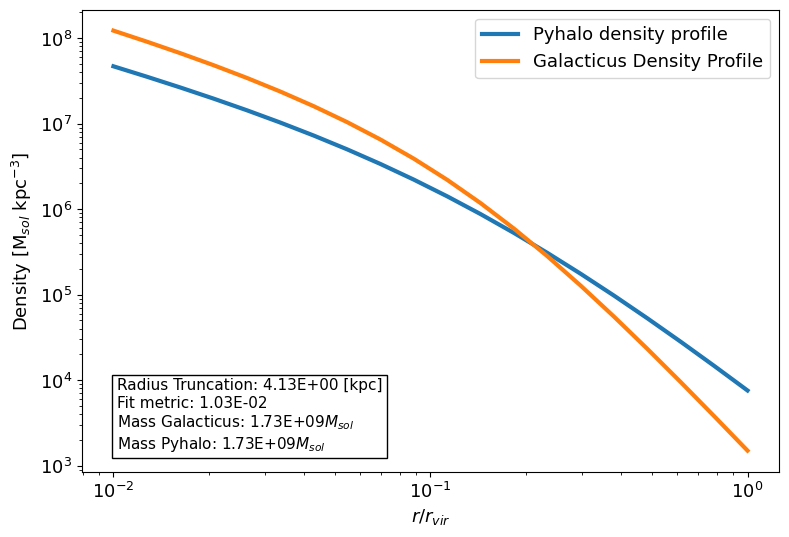

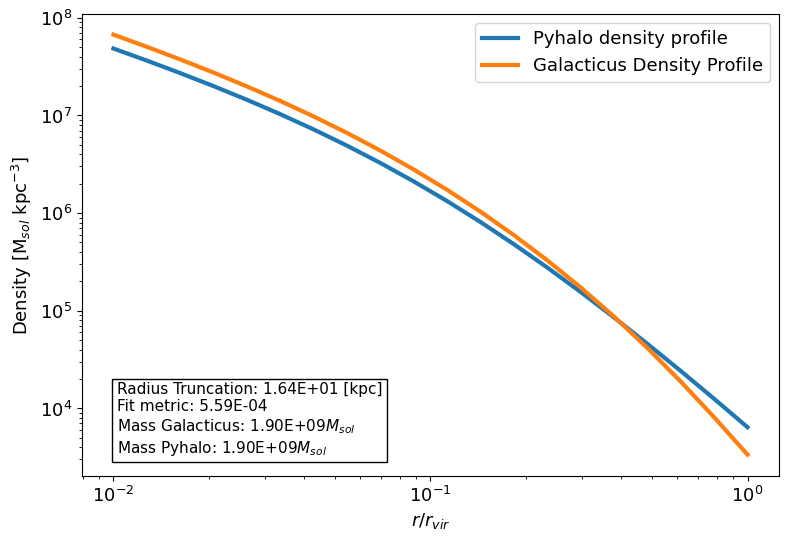

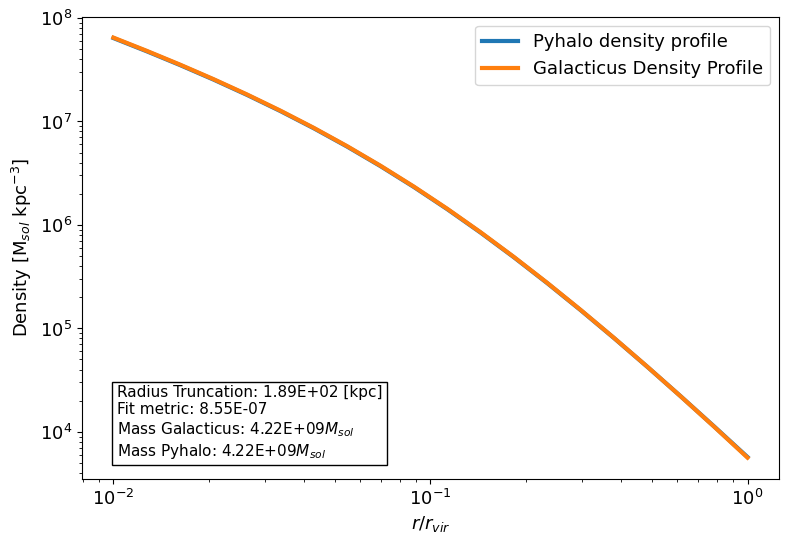

In [66]:
plt.rcParams.update({"font.size":13})

def plt_compare_density(ax:Axes,subhalos:list[TNFWFromParams],nodedata:dict[str,np.ndarray],n:int):
    r = nodedata[GalacticusParameters.DENSITY_PROFILE_RADIUS][n] * 1E3

    subhalo = subhalos[n]
    
    rv = subhalo.params_physical[TNFWFromParams.KEY_RV]
    
    ax.plot(r / rv,subhalo.density_profile_3d(r),label="Pyhalo density profile",linewidth=3)
    ax.plot(r / rv,nodedata[GalacticusParameters.DENSITY_PROFILE][n] / 1E9, label="Galacticus Density Profile",linewidth=3)

    #ax.vlines(x=subhalo.params_physical[TNFWFromParams.KEY_RS],ymin=4E3,ymax=1E8,linestyle="dashed")
    #ax.hlines(y=subhalo.params_physical[TNFWFromParams.KEY_RHO_S] / 4, xmin=2E-1,xmax=2E1,linestyles="dashed")


    txt_rt = f"Radius Truncation: {subhalo.params_physical[TNFWFromParams.KEY_RT]:.2E} [kpc]"
    #print(nodedata[GalacticusParameters.TNFW_RADIUS_TRUNCATION][n])
    txt_fit_metric = f"Fit metric: {nodedata['metricTidalTruncationNFW'][n]:.2E}"
    txt_mass_galacticus = f"Mass Galacticus: {nodedata[GalacticusParameters.MASS_BOUND][n]:.2E}" + r"$M_{sol}$"
    txt_mass_pyhalo = f"Mass Pyhalo: {subhalo.bound_mass:.2E}"+ r"$M_{sol}$"
    
    newline = "\n"
    txt_box = txt_rt + newline + txt_fit_metric + newline + txt_mass_galacticus + newline + txt_mass_pyhalo

    props = {"boxstyle":"square","facecolor":"white"}
    ax.text(0.05, 0.05, txt_box,transform=ax.transAxes,fontsize=11, bbox=props)

    ax.set_ylabel(r"Density [M$_{sol}$ kpc$^{-3}$]")
    ax.set_xlabel(r"$r/r_{vir}$")

    

fig, ax = plt.subplots(figsize = (9, 6))
plt_compare_density(ax,subhalos,nodedata,46)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

fig, ax = plt.subplots(figsize = (9, 6))
plt_compare_density(ax,subhalos,nodedata,60)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

fig, ax = plt.subplots(figsize = (9, 6))
plt_compare_density(ax,subhalos,nodedata,49)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

fig, ax = plt.subplots(figsize = (9, 6))
plt_compare_density(ax,subhalos,nodedata,11)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

11